# Code adapted from "Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles"
This is the code from the paper entitled "[**Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles**](https://arxiv.org/pdf/1910.08635.pdf)" published in IEEE GlobeCom 2019.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, Ismail Hamieh, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

## Random Forest, Extra Trees, XGBoost, Decision Trees

## Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Code based on CICIDS2017, adapted to UNSW-NB15

In [ ]:
#Read dataset
df = pd.read_csv('/content/Train_Test_Windows_10.csv')
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [10] if you work on the sampled dataset.

In [ ]:
df

,Processor_DPC_Rate,Processor_pct_ Idle_Time,Processor_pct_ C3_Time,Processor_pct_ Interrupt_Time,Processor_pct_ C2_Time,Processor_pct_ User_Time,Processor_pct_ C1_Time,Processor_pct_ Processor_Time,Processor_C1_ransitions_sec,Processor_pct_ DPC_Time,...,LogicalDisk(_Total) Avg Disk Write Queue Length,LogicalDisk(_Total) Avg Disk Queue Length,LogicalDisk(_Total) pct_ Disk Read Time,LogicalDisk(_Total) Disk Write Bytes sec,LogicalDisk(_Total) Disk Transfers sec,LogicalDisk(_Total) Avg Disk Bytes Transfer,LogicalDisk(_Total) pct_ Disk Write Time,LogicalDisk(_Total) Avg Disk sec Transfer,label,type
0,0,49.07244938,0,0.779671928,0,21.830814,49.07244938,45.5788994,405.2109934,0.155934386,...,0.035543669,0.035727836,0.006138575,980725.4671,61.12065428,16125.91191,1.184788963,0.000584015,1,dos
1,17,0,0,1.170522789,0,38.15904291,0,100,0,2.41908043,...,0.071868506,0.113428645,1.38968492,695437.4911,56.84042385,17923.5993,2.403132421,0.001995776,1,dos
2,11,0,0,0.546510062,0,65.1127703,0,100,0,0.312291464,...,0.010271601,0.023255341,0.432790999,691341.4197,9.388015072,86462.6383,0.342387367,0.002475624,1,dos
3,0,0,0,0.78081667,0,68.94611198,0,100,0,1.015061671,...,0.062088903,0.070302274,0.273779061,1039903.208,81.89439351,13206.97436,2.069629418,0.000858868,1,dos
4,0,0,0,0.468739969,0,66.0142123,0,100,0,0.156246656,...,0.100304043,0.123923448,0.787313151,2498188.869,190.1717481,15214.36803,3.34346845,0.000651557,1,dos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21099,0,48.02591125,0,0.234004125,0,43.52476716,48.02591125,50.0791201,147.5671891,0.15600275,...,0.001008811,0.001143588,0.004491881,11859.68944,1.297952273,14493.53846,0.033627703,0.000881077,1,mitm
21100,0,63.66271811,0,0.078245719,0,30.75056759,63.66271811,34.35184171,165.8555585,0,...,0.001484681,0.001533736,0.001635523,29946.94375,4.30663588,8477.767442,0.049489353,0.000356133,1,mitm
21101,1,82.34150729,0,0,0,15.21082955,82.34150729,16.30143536,189.6071196,0,...,0.000447637,0.000447637,0,15182.94736,1.497686568,10137.6,0.014921902,0.000298887,1,mitm
21102,0,38.79268029,0,0.156245925,0,23.04627395,38.79268029,59.84479725,172.9953291,0.156245925,...,0.000617754,0.000690462,0.002422937,12697.25717,0.899975701,17749.33333,0.020592463,0.0007672,1,mitm


In [ ]:
df.type.value_counts()

type
normal       10000
ddos          4608
password      3628
xss           1269
injection      612
dos            525
scanning       447
mitm            15
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [ ]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

In [ ]:
df.replace(to_replace=' ', value=0, inplace=True)

### split train set and test set

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['label', 'type'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
if X_train.dtype not in [int, 'int32', 'int64', float]:
    X_train = X_train.astype(float)
if X_test.dtype not in [int, 'int32', 'int64', float]:
    X_test = X_test.astype(float)

In [ ]:
pd.Series(y_train).value_counts()

4    8000
0    3686
5    2902
7    1015
2     490
1     420
6     358
3      12
Name: count, dtype: int64

### Oversampling by SMOTE

In [ ]:
print(y_train)

if y_train.dtype not in [int, 'int32', 'int64']:
    y_train = y_train.astype(int)
if y_test.dtype not in [int, 'int32', 'int64']:
    y_test = y_test.astype(int)

pd.Series(y_train).value_counts()

[4 7 4 ... 4 0 0]


4    8000
0    3686
5    2902
7    1015
2     490
1     420
6     358
3      12
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={3:350}) # Create 1500 samples for the minority class "4"

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

4    8000
0    3686
5    2902
7    1015
2     490
1     420
6     358
3     350
Name: count, dtype: int64

In [ ]:
X_train

array([[5.12820513e-03, 5.19576440e+01, 0.00000000e+00, ...,
        1.79588602e+04, 5.84503657e+00, 9.83379000e-04],
       [0.00000000e+00, 7.12195552e+01, 0.00000000e+00, ...,
        6.14400000e+03, 7.47530400e-03, 3.74333000e-04],
       [0.00000000e+00, 8.45621101e+01, 0.00000000e+00, ...,
        1.96608000e+04, 1.04485410e-02, 6.27920000e-04],
       ...,
       [0.00000000e+00, 5.45249010e+01, 0.00000000e+00, ...,
        1.36849490e+04, 1.37967840e-02, 4.55036592e-04],
       [0.00000000e+00, 8.79028542e+01, 0.00000000e+00, ...,
        1.48638886e+04, 5.16194037e-02, 3.12452231e-04],
       [0.00000000e+00, 7.78948900e+01, 0.00000000e+00, ...,
        1.46707175e+04, 1.11020124e-01, 4.44475884e-04]])

In [ ]:
X_test

array([[1.48717949e-01, 3.81418564e+01, 0.00000000e+00, ...,
        1.25553345e+04, 6.59278325e-01, 2.48122000e-04],
       [2.56410256e-02, 6.52041624e+01, 0.00000000e+00, ...,
        1.41609573e+04, 1.59751484e-01, 2.29176000e-04],
       [0.00000000e+00, 2.49886171e+01, 0.00000000e+00, ...,
        7.91170803e+03, 1.94514790e-01, 4.27190000e-04],
       ...,
       [0.00000000e+00, 5.18850407e+01, 0.00000000e+00, ...,
        2.22782556e+04, 1.74545917e-01, 1.05661200e-03],
       [0.00000000e+00, 5.83305732e+01, 0.00000000e+00, ...,
        1.59744000e+04, 9.19916300e-03, 2.75990000e-04],
       [1.53846154e-02, 2.03555423e+01, 0.00000000e+00, ...,
        6.15329878e+04, 3.93719362e+00, 3.35208000e-04]])

In [ ]:
y_train

array([4, 7, 4, ..., 3, 3, 3])

In [ ]:
y_test

array([4, 5, 7, ..., 0, 0, 4])

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.9997630893153281
Precision of DT: 0.999822316986496
Recall of DT: 0.9997630893153281
F1-score of DT: 0.9997793422678681
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      0.99      0.99        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       0.97      1.00      0.98      4221
weighted avg       1.00      1.00      1.00      4221



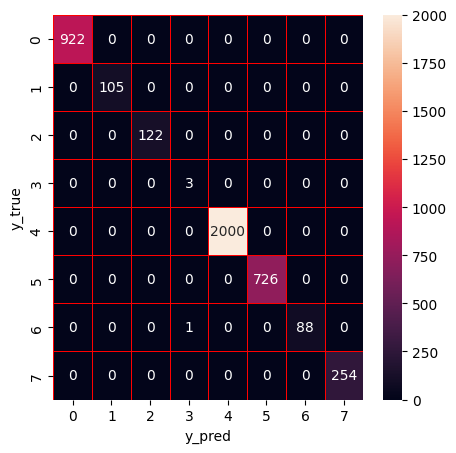

In [ ]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



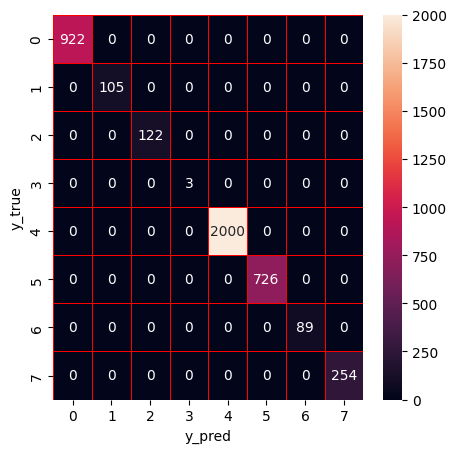

In [ ]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



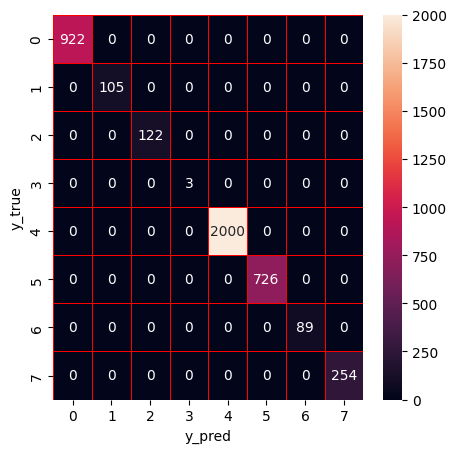

In [ ]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



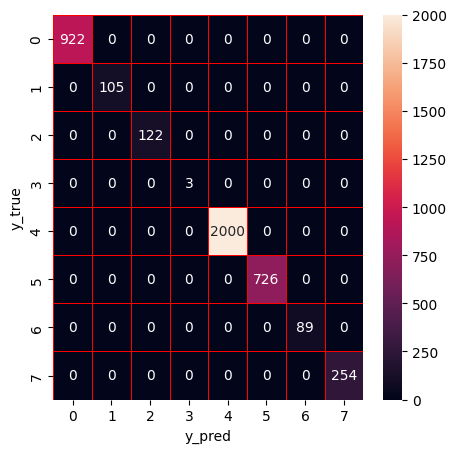

In [ ]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [ ]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,7,7,7,7
2,4,4,4,4
3,0,0,0,0
4,5,5,5,5


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9997630893153281
Precision of Stacking: 0.999822316986496
Recall of Stacking: 0.9997630893153281
F1-score of Stacking: 0.9997793422678681
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      0.99      0.99        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       0.97      1.00      0.98      4221
weighted avg       1.00      1.00      1.00      4221



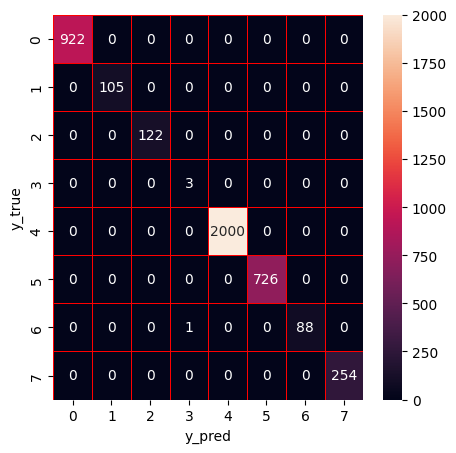

In [ ]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [ ]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [ ]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [ ]:
feature=(df.drop(['label', 'type'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.2295, 'Process_Virtual_Bytes Peak'), (0.1196, 'Memory System Driver Total Bytes'), (0.054, 'Network_I(Intel R _82574L_GNC)TCP_APS'), (0.0498, 'Network_I(Intel R _82574L_GNC) Bytes Sent sec'), (0.0437, 'Process_Thread Count'), (0.0392, 'Process_Virtual_Bytes'), (0.0392, 'Memory Cache Bytes Peak'), (0.0369, 'Process_Handle Count'), (0.0363, 'Memory Pool Nonpaged Bytes'), (0.0306, 'Process_Pool_Paged Bytes'), (0.0298, 'LogicalDisk(_Total) pct_ Free Space'), (0.0193, 'Memory Pool Paged Resident Bytes'), (0.0176, 'Process_Working Set'), (0.0176, 'Memory System Driver Resident Bytes'), (0.0168, 'Memory Standby Cache Reserve Bytes'), (0.0134, 'Memory Long-Term Average Standby Cache Lifetime (s)'), (0.013, 'LogicalDisk(_Total) Free Megabytes'), (0.0116, 'Memory System Cache Resident Bytes'), (0.0113, 'Process_Working_Set_Peak'), (0.0105, 'Memory Commit Limit'), (0.0096, 'Memory Free System Page Table Entries'), (0.0088, 'Memory Pool Paged Bytes'), (0.0084, '

In [ ]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [ ]:
len(f_list)

124

In [ ]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break

In [ ]:
X_fs = df[fs].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(16883, 29)

In [ ]:
pd.Series(y_train).value_counts()

4    8000
0    3686
5    2902
7    1015
2     490
1     420
6     358
3      12
Name: count, dtype: int64

### Oversampling by SMOTE

In [ ]:
print(y_train)

if y_train.dtype not in [int, 'int32', 'int64']:
    y_train = y_train.astype(int)
if y_test.dtype not in [int, 'int32', 'int64']:
    y_test = y_test.astype(int)

pd.Series(y_train).value_counts()

[4 7 4 ... 4 0 0]


4    8000
0    3686
5    2902
7    1015
2     490
1     420
6     358
3      12
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={3:350}) # Create 1500 samples for the minority class "4"

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

4    8000
0    3686
5    2902
7    1015
2     490
1     420
6     358
3     350
Name: count, dtype: int64

In [ ]:
X_train

array([[1.50858175e-01, 3.94707333e-02, 0.00000000e+00, ...,
        7.22995390e-03, 4.78892304e-01, 4.70669724e+04],
       [8.37398374e-01, 5.07512895e-01, 4.54144366e-01, ...,
        2.30083446e-02, 8.46043601e-01, 1.36085202e+02],
       [2.90876242e-01, 1.02713613e-01, 4.16244756e-01, ...,
        1.14626413e-02, 5.50344762e-01, 5.53129678e+01],
       ...,
       [9.09657057e-01, 1.05873089e-01, 6.07519129e-01, ...,
        2.29257514e-02, 8.02412802e-01, 2.76130678e+02],
       [9.23609071e-01, 9.11979831e-02, 6.39441920e-01, ...,
        2.18182270e-02, 6.87893439e-01, 7.52847072e+01],
       [8.92681144e-01, 9.73405650e-02, 6.27357614e-01, ...,
        2.18686585e-02, 7.17901503e-01, 7.94401856e+01]])

In [ ]:
X_test

array([[0.3405600722673893, 0.10293787844808253, 0.4022855489657168, ...,
        0.020161667898699047, 0.5618898991990063, '57.44607726'],
       [0.7560975609756098, 0.15294909172460192, 0.6125415883118762, ...,
        0.018452455699547635, 0.8439893625491663, '6358.404398'],
       [0.8373983739837398, 0.9865440681767212, 0.31129755533053666, ...,
        0.0288419621326573, 0.8515693424845135, '370.4543516'],
       ...,
       [0.7967479674796748, 0.09284592958062346, 0.7713004484304933, ...,
        0.023729859674409468, 0.718027931270602, '1973.936148'],
       [0.7470641373080398, 0.09284592958062346, 0.7295674815564878, ...,
        0.021380915071822663, 0.8940554485086867, '92.44832508'],
       [0.11924119241192412, 0.0423861852433281, 0.0, ...,
        0.011146567276198114, 0.01375861904231094, '148.9439536']],
      dtype=object)

In [ ]:
y_train

array([4, 7, 4, ..., 3, 3, 3])

In [ ]:
y_test

array([4, 5, 7, ..., 0, 0, 4])

## Machine learning model training after feature selection

Accuracy of DT: 1.0
Precision of DT: 1.0
Recall of DT: 1.0
F1-score of DT: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



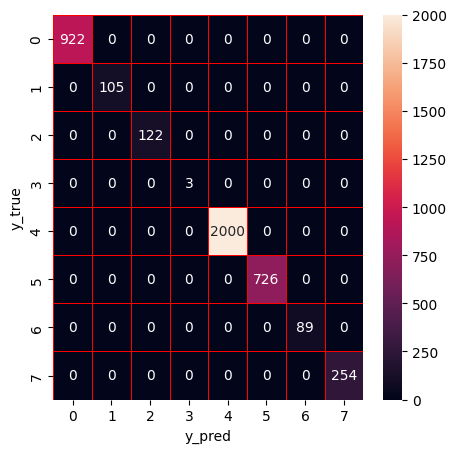

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



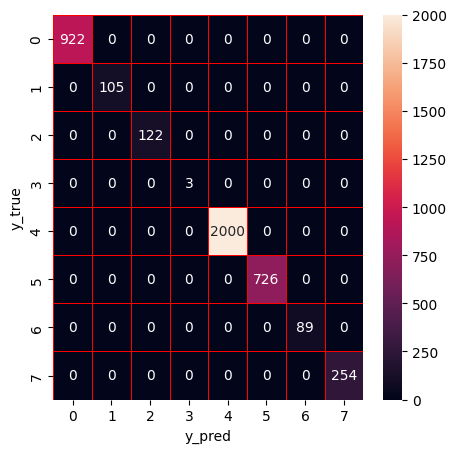

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



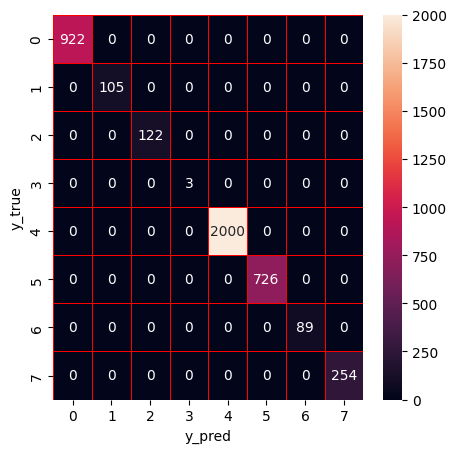

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



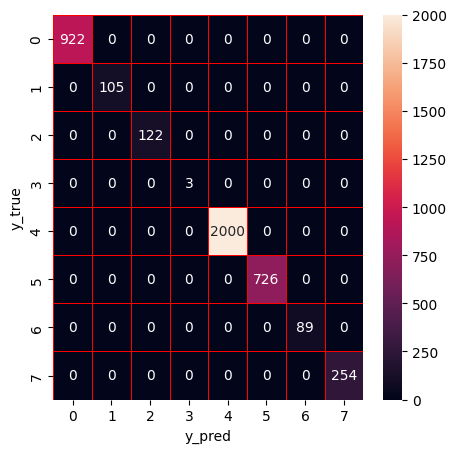

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,7,7,7,7
2,4,4,4,4
3,0,0,0,0
4,5,5,5,5


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 1.0
Precision of Stacking: 1.0
Recall of Stacking: 1.0
F1-score of Stacking: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00       254

    accuracy                           1.00      4221
   macro avg       1.00      1.00      1.00      4221
weighted avg       1.00      1.00      1.00      4221



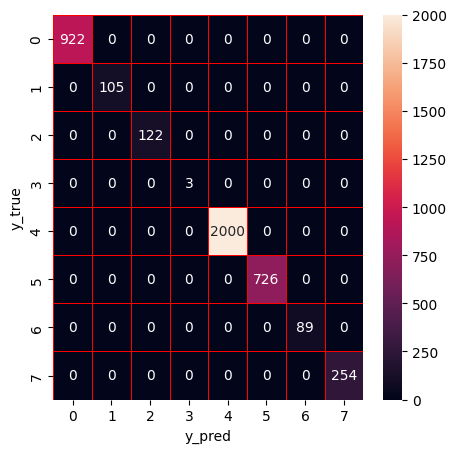

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()